In [4943]:
import numpy as np
from scipy.stats import beta, multivariate_normal, multinomial
import matplotlib.pyplot as plt
from scipy.special import psi, gammaln, digamma, betaln, logsumexp, gamma
import scipy.special as sc
from numpy.linalg import inv, det
from sklearn.mixture import BayesianGaussianMixture
import itertools
import matplotlib as mpl
from scipy import linalg
import sys

np.random.seed(0)

In [4944]:
def generate_data_gg_dp(K, alpha, N, mu_baseline, cov_baseline, sample_cov, N_held_out=100, held_out=False):
    '''
    @params: K:=number of possible clusters
             alpha:=etas are drawn from Beta(1, alpha)
             N:=number of data points to be generated
             cov_baseline:=covariance matrix of the baseline gaussian distribution
             cov:=covariance matrix of the "local" gaussian distributions
             N_held_out:=number of held out data points generated if held_out=True
             held_out:=boolean that indicated wether or not to generate hold out data
    @returns: X:=Nx2 matrix where each collumn is a data point
              if held_out=True, also returns:
                X_heldout:=X_held_outx2 matrix, where each collumn is a data point
    '''
    X = []
    # draw mean from DP with baseline gaussian distribution
    V = beta.rvs(a=1, b=alpha, size=K-2)
    V = np.append(V, 1)
    print("V: \n", V)
    # get importances from V
    THETA = [V[i]*np.prod(1 - V[:i]) for i in range(K-1)]
    THETA = np.append(THETA, 0)
    THETA = THETA/sum(THETA)
    print("Theta:\n", THETA)
    # draw from prior gaussian
    MU = multivariate_normal.rvs(mean=mu_baseline, cov=cov_baseline, size=K)
    # for each data point ...
    for n in range(N):
        # draw from MU with importances from THETA
        mu_idx_s = np.random.choice([i for i in range(K)], p=THETA)
        mu_s = MU[mu_idx_s]
        # draw point from normal with mean mu_s and diagonal covriance
        x = multivariate_normal.rvs(
            mean=mu_s, cov=sample_cov)
        # append point to X
        X.append(list(x))
    if not held_out:
        # return the DATA
        return np.array(X), MU
    else:
        X_held_out = []
        # generate N_held_out_points
        for n in range(N_held_out):
            # draw from MU with importances from THETA
            mu_idx_s = np.random.choice([i for i in range(K)], p=THETA)
            mu_s = MU[mu_idx_s]
            # draw point from normal with mean mu_s and diagonal covriance
            x = multivariate_normal.rvs(
                mean=mu_s, cov=sample_cov)
            # append point to X
            X_held_out.append(list(x))
        # return DATA plus HELD_OUT 
        return np.array(X), np.array(X_held_out)
    
def plot_data(X, ax):
    ax.plot(X[:, 0], X[:, 1], '.', c="black")

In [4945]:
def auto_correlation(a, b, D):
    e = multivariate_normal.rvs(mean=a, cov=b, size=K)
    S = e.T @ e

    return S

[[2.89632802 0.07555469]
 [0.07555469 2.0256294 ]]
V: 
 [0.05023345 0.73423507 0.03945283 0.18136743 0.03122086 0.06434116
 0.23349983 0.22589519 0.07811415 0.10256618 0.0106862  0.0709217
 0.16845614 0.02377449 0.05905035 0.41860065 0.13988294 0.0877821
 1.        ]
Theta:
 [0.05023345 0.69735191 0.00995847 0.04397365 0.00619679 0.01237189
 0.04200985 0.03115185 0.00833885 0.01009388 0.0009438  0.00619683
 0.01367506 0.00160487 0.00389135 0.02595638 0.00504294 0.00272196
 0.02828622 0.        ]


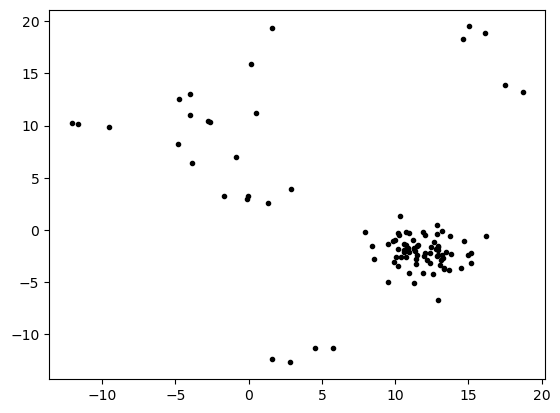

In [4946]:
K = 20
alpha = 5
N = 100
baseline_mu = np.zeros(2)
baseline_cov = np.diag([100, 100])
sigma = auto_correlation(np.array([0, 0]), np.eye(2) / 10, 2)

# sample_cov = np.array([[2 , 1],\
#                        [1 , 2]])
print(sigma)
sample_cov = sigma

# gen data
X, mu_x_gen = generate_data_gg_dp(K = K, alpha = alpha, N = N, mu_baseline = baseline_mu, cov_baseline = baseline_cov, sample_cov = sample_cov)

ax = plt.subplot(111)
plot_data(X, ax)
plt.show()

In [4947]:
def plot_data_and_cluster(X, mu_k, ax):
    ax.plot(X[:, 0], X[:, 1], '.', c="dodgerblue", alpha = 0.4)
    ax.plot(mu_k[:, 0], mu_k[:, 1], '*', c="firebrick", markersize = 10, alpha = 0.8)

In [4948]:
def prediction(X, gamma1, gamma2, mu, cov, num_esimate):
    T = mu.shape[0]
    D = X.shape[1]

    log_g1 = np.log(gamma1)
    log_g2 = np.log(gamma2)
    log_gs = np.log(gamma1 + gamma2)

    log_p_T = np.zeros((T,))
    temp = 0

    for i in range(T):
        if i < T - 1:
            log_p_T[i] = temp + log_g1[i] - log_gs[i]
        else:
            log_p_T[i] = temp
        temp += log_g2[i] - log_gs[i]

    cov_inv = inv(cov)
    log_det_cov = np.log(det(cov))

    M = np.size(X, 0)
    log_prob = np.ones((M, T)) * (- D / 2 * np.log(2 * np.pi))
    for n in range(M):
        for i in range(T):
            log_prob[n, i] += - 0.5 * log_det_cov - 0.5 * (X[n] - mu[i]) @ cov_inv @ (X[n] - mu[i]) 

    predict_prob_0 = log_prob + log_p_T #(should be N, T)

    log_prob_t = np.ones((M, T)) * (gammaln((num_esimate + 1 + D) / 2) - gammaln((num_esimate + 1) / 2) - D/2 * np.log((num_esimate + 1)*np.pi) - 0.5* np.log(det(cov)))
    for j in range(M):
        for i in range(T):
            log_prob_t[j, i] += - ((num_esimate + 1 + D) / 2) * np.log(1 + (1 / (N + 1)) * (X[j] - mu[i]) @ cov_inv @ (X[j] - mu[i]))

    predict_prob = log_prob_t + log_p_T #(should be N, T)

    label = np.argmax(predict_prob, axis = 1)
    label_0 = np.argmax(predict_prob_0, axis = 1)
    predict = logsumexp(predict_prob, axis = 1)
    predict_0 = logsumexp(predict_prob_0, axis = 1)

    return predict_0, predict, label_0, label

In [4949]:
def plot_contour(X, gamma1, gamma2, mu, cov, num_esimate, M = 51):
    min_values = np.min(X, axis=0) * 1.2
    max_values = np.max(X, axis=0) * 1.2
    xv, yv = np.meshgrid(np.linspace(min_values[0], max_values[0], M), np.linspace(min_values[1], max_values[1], M))
    xy = np.stack((xv, yv), axis=-1).reshape((M * M, 2))
    _, prob, _, _ = prediction(xy, gamma1, gamma2, mu, cov, num_esimate)
    
    z = np.reshape(prob , (M, M))

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], 0.8)
    plt.contour(xv, yv, z)
    plt.show()

In [4950]:
color_iter = itertools.cycle([
    "firebrick",    # A strong red
    "dodgerblue",   # A vivid blue
    "chartreuse",   # A bright green-yellow
    "fuchsia",      # A vivid pink-purple
    "gold",         # A bright yellow
    "darkviolet",   # A deep purple
    "orange"        # A clear orange
])

In [4951]:
def plot_el(X, gamma1, gamma2, mu, cov, num_esimate, label_input = None, M = 51):
    T = mu.shape[0]
    if label_input is None:
        _, _, _, label = prediction(X, gamma1, gamma2, mu, cov, num_esimate)
        cov = np.array([cov * 1e6 for _ in range(T)])
    else:
        label = label_input
        cov = np.array([cov for _ in range(T)])

    splot = plt.subplot(1, 1, 1)
    for i, (mu, cov, color) in enumerate(zip(mu, cov, color_iter)):
        v, w = linalg.eigh(cov)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(label == i):
            continue # get rid off redundant
        plt.scatter(X[label == i, 0], X[label == i, 1], 4, color=color)

    return label

In [4952]:
def plot_elbo(elbo_values):
    plt.figure(figsize=(10, 6))
    plt.plot(elbo_values, label='ELBO')
    plt.title('ELBO')
    plt.xlabel('n_iter')
    plt.ylabel('ELBO')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4953]:
def ELBO(X, a, B, nu, phi, Gamma1, Gamma2, M_cov):
    N, D = X.shape
    T = nu.shape[0]
    cov_x = np.cov(X.T)
    cov_x_inv = inv(cov_x)

    a_i = np.array([(a - (i + 1) + 1) / 2 for i in range(D)])
    diff = nu[:, np.newaxis, :] - X[np.newaxis, :, :] # T, N, D
    E_log_p_x = N * ( - D/2 * np.log(np.pi) + D/2 * np.log(det(B)) + 0.5 * np.sum(digamma(a_i))) \
            + np.sum(phi * (0.5 * (np.trace(a * B * inv(M_cov), axis1=1, axis2=2).reshape(T, 1) + np.einsum('tnd,dm,tnm->tn', diff, a * B, diff))))
    
    Eq_logV = digamma(Gamma1) - digamma(Gamma1 + Gamma2)
    Eq_log1_V = digamma(Gamma2) - digamma(Gamma1 + Gamma2)
    cum_phi = np.cumsum(phi[::-1,:], axis=0)[::-1,:]

    E_log_p_Z = np.sum(np.einsum('ij, ik -> ij', phi, Eq_logV) + np.einsum('ij, ik -> ij', cum_phi,  Eq_log1_V))

    E_log_p_V = (alpha - 1) * np.sum(Eq_log1_V) - (T - 1) * sc.beta(1, alpha)
    
    E_log_q_Z = - np.sum(np.einsum('ij, ij -> ij', phi, np.log(phi)))

    E_log_q_V = ((Gamma1 - 1).T @ Eq_logV + (Gamma2 - 1).T @ Eq_log1_V).item() - np.sum(betaln(Gamma1, Gamma2))
    
    diff_pq_mu = -0.5 * T * np.log(det(cov_x)) + np.sum(np.trace(cov_x_inv * inv(M_cov), axis1=1, axis2=2)) - np.sum(np.log(det(M_cov))) \
                 - 0.5 * np.sum(np.einsum('ti, ij, tj -> t', nu, cov_x_inv, nu)) + T * D /2
    
    D_i = np.array([(D - (i + 1) + 1) / 2 for i in range(D)])
    diff_E_pq_sigma = D / 2 * np.log(det(B)) - a / 2 * (np.trace(B) - D) -\
                      np.sum(gammaln(D_i)) + np.sum(gammaln(a_i)) - (a - D) / 2 * np.sum(digamma(a_i))

    elbo = E_log_p_x + E_log_p_Z + E_log_p_V + diff_pq_mu + diff_E_pq_sigma \
          - (E_log_q_Z + E_log_q_V)

    return elbo

In [4954]:
def var_dpmm(X, alpha, T = K, n_iter = 100):
    N, M = X.shape
    D = M
    mean_x = np.mean(X, axis = 0)
    cov_x = np.cov(X.T)
    var_x = np.diag(np.var(X, axis = 0)) / T
    cov_x_inv = inv(cov_x)
    var_x_inv = inv(var_x)
    # P = np.diag(var_x_inv)

    I = np.eye(D)

    phi = np.array(np.random.random((T,N)))
    phi = np.divide(phi, np.sum(phi, axis=0))

    gamma1 = np.array(np.ones((T, 1)))
    gamma2 = np.array(np.ones((T, 1)))

    nu_k = np.array([mean_x for _ in range(T)])

    a = D
    B = cov_x_inv

    lmbda1 = np.array([0, 0])
    lmbda2 = 0

    tau1 = 0
    tau2 = 0

    elbo = []

    for i_iter in range(n_iter):
        #sys.stdout.write('*'); sys.stdout.flush()

        for i in range(T):
            gamma1[i] = 1. + np.sum(phi[i, :])
            gamma2[i] = alpha + np.sum(phi[i + 1 : T, :])
            
        tau1 = np.einsum('ij, jk -> ik', phi, X)
        tau2 = np.sum(phi, axis = 1).reshape((T, 1))

        Eq_logV = digamma(gamma1) - digamma(gamma1 + gamma2)
        Eq_logV[-1] = 0
        Eq_log1_V = digamma(gamma2) - digamma(gamma1 + gamma2)
        cum_Eq_log1_V = np.cumsum(Eq_log1_V, axis=0)
        cum_Eq_log1_V = np.vstack((0., cum_Eq_log1_V[:-1]))

        # cluster_dist = np.sum(phi, axis = 1).reshape((T, 1))
        M_cov = inv(cov_x_inv + a * B * tau2[:, :, np.newaxis])
        # nu_k_first = inv(cov_x_inv + a * B * tau2[:, :, np.newaxis])
        nu_k_first = M_cov
        nu_k_second = a * np.einsum('ij, tj -> ti', B.T, tau1)
        nu_k = np.einsum('tij, tj -> ti', nu_k_first, nu_k_second).reshape((T, M))

        a = N + D
        diff = nu_k[:, np.newaxis, :] - X[np.newaxis, :, :] # T, N, D

        outer_X_nu = np.einsum('tnd,tnp->tndp', diff, diff) # T, N, D, D
        phi_re = phi[:, :, np.newaxis, np.newaxis]
        B = inv(np.sum(phi_re * outer_X_nu, axis = (0, 1)) + (N + 1) * I)
        # B = inv(np.sum(phi_re * outer_X_nu, axis = (0, 1)) + I)

        a_i = np.array([(a - (i + 1) + 1) / 2 for i in range(D)])
        const = - D/2 * np.log(np.pi) + D/2 * np.log(det(B)) + 0.5 * np.sum(digamma(a_i))
        Eq_p_x = const - a / 2 * (np.trace(B * inv(M_cov), axis1=1, axis2=2).reshape(T, 1) + np.einsum('tnd,dm,tnm->tn', diff, B, diff))
    
        phi = np.exp(Eq_logV + cum_Eq_log1_V + Eq_p_x)
        phi = phi / np.sum(phi, axis = 0).reshape(1, N)

        elbo.append(ELBO(X, a, B, nu_k, phi, gamma1, gamma2, M_cov))

        if len(elbo) > 1:
          elbo_diff = np.abs(elbo[-1] - elbo[-2])
          if elbo_diff < 1e-2:
            print("Converge at:", i_iter)
            break

    cov_infer = inv(B) * (1 + 1 / N) / (N + 1)
    print(cov_infer)

    predict_0, predict, _, label = prediction(X, gamma1, gamma2, nu_k, cov_infer, N)

    comp = 0
    for i in range(T):
      if np.any(label == i):
        comp += 1
    print("Components:", comp)

    # log_likelihood_0 = np.sum(predict_0)
    # print('Log-likelihood_0:',log_likelihood_0)

    # log_likelihood = np.sum(predict)

    # print('Log-likelihood:',log_likelihood)

    plot_el(X, gamma1, gamma2, nu_k, cov_infer, N, label_input = None,)
    plot_contour(X, gamma1, gamma2, nu_k, cov_infer, N)

    return elbo, nu_k

Converge at: 38
[[ 3.64200556 -0.39251002]
 [-0.39251002  3.06391898]]
Components: 9


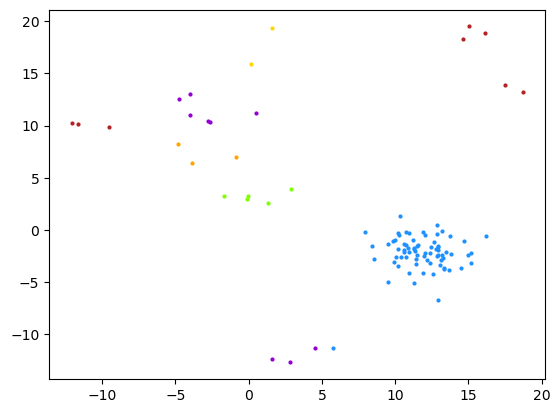

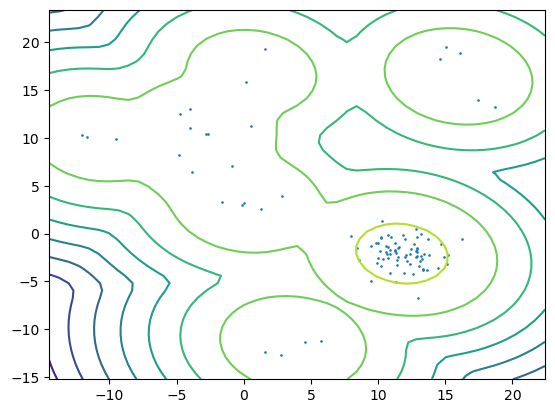

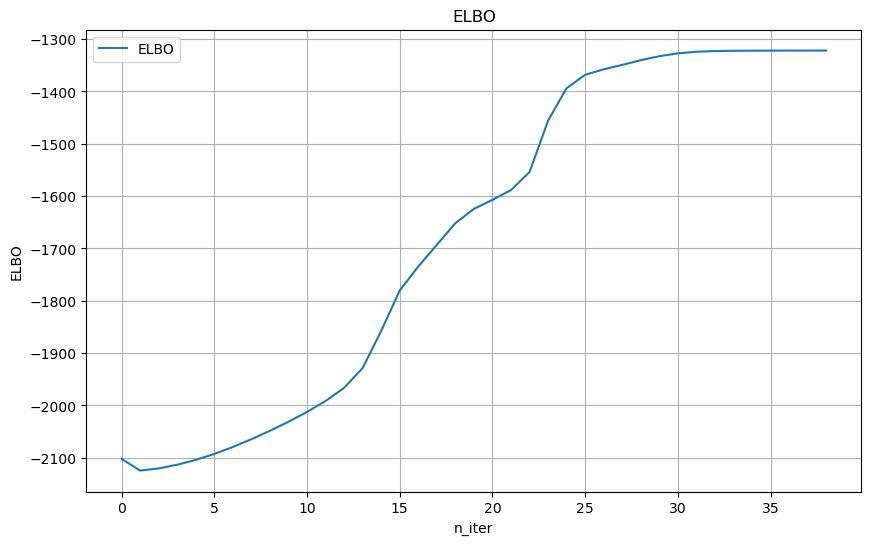

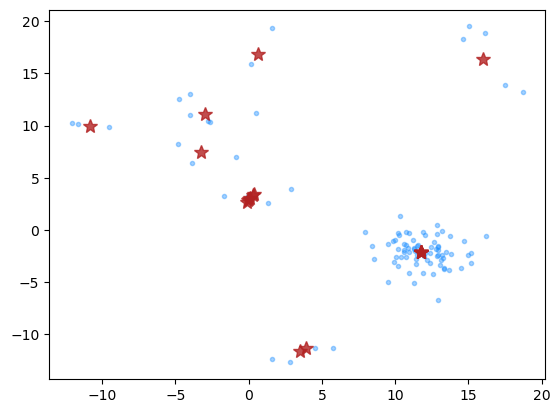

In [4955]:
elbo, mu_k_our = var_dpmm(X, alpha, T=K, n_iter=1000)
plot_elbo(elbo)

ax = plt.subplot(111)
plot_data_and_cluster(X, mu_k_our, ax)
plt.show()

In [4956]:
def plot_contour_n(X, gamma1, gamma2, mu, cov, num_esimate, M = 51):
    min_values = np.min(X, axis=0) * 1.2
    max_values = np.max(X, axis=0) * 1.2
    xv, yv = np.meshgrid(np.linspace(min_values[0], max_values[0], M), np.linspace(min_values[1], max_values[1], M))
    xy = np.stack((xv, yv), axis=-1).reshape((M * M, 2))
    prob, _, _, _ = prediction(xy, gamma1, gamma2, mu, cov, num_esimate)
    
    z = np.reshape(prob , (M, M))

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], 0.8)
    plt.contour(xv, yv, z)
    plt.show()

In [4957]:
def plot_el_n(X, gamma1, gamma2, mu, cov, num_esimate, label_input = None, M = 51):
    T = mu.shape[0]
    if label_input is None:
        _, _, label, _ = prediction(X, gamma1, gamma2, mu, cov, num_esimate)
        cov = np.array([cov * 1e6 for _ in range(T)])
    else:
        label = label_input
        cov = np.array([cov for _ in range(T)])

    splot = plt.subplot(1, 1, 1)
    for i, (mu, cov, color) in enumerate(zip(mu, cov, color_iter)):
        v, w = linalg.eigh(cov)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(label == i):
            continue # get rid off redundant
        plt.scatter(X[label == i, 0], X[label == i, 1], 4, color=color)

    return label

In [4958]:
def ELBO_n(X, nu, phi, sigma, Gamma1, Gamma2, M_cov):
    N, D = X.shape
    T = nu.shape[0]
    cov_x = np.cov(X.T)
    cov_x_inv = inv(cov_x)

    diff = nu[:, np.newaxis, :] - X[np.newaxis, :, :] # T, N, D
    E_log_p_x = N * ( - D/2 * np.log(np.pi) - 1/2 * np.log(det(sigma))) \
            + np.sum(phi * (0.5 * (np.trace(sigma * M_cov, axis1=1, axis2=2).reshape(T, 1) + np.einsum('tnd,dm,tnm->tn', diff, inv(sigma), diff))))
    
    Eq_logV = digamma(Gamma1) - digamma(Gamma1 + Gamma2)
    Eq_log1_V = digamma(Gamma2) - digamma(Gamma1 + Gamma2)
    cum_phi = np.cumsum(phi[::-1,:], axis=0)[::-1,:]

    E_log_p_Z = np.sum(np.einsum('ij, ik -> ij', phi, Eq_logV) + np.einsum('ij, ik -> ij', cum_phi,  Eq_log1_V))

    E_log_p_V = (alpha - 1) * np.sum(Eq_log1_V) - (T - 1) * sc.beta(1, alpha)
    
    E_log_q_Z = - np.sum(np.einsum('ij, ij -> ij', phi, np.log(phi)))

    E_log_q_V = ((Gamma1 - 1).T @ Eq_logV + (Gamma2 - 1).T @ Eq_log1_V).item() - np.sum(betaln(Gamma1, Gamma2))
    
    diff_pq_mu = -0.5 * T * np.log(det(cov_x)) + np.sum(np.trace(cov_x_inv * inv(M_cov), axis1=1, axis2=2)) - np.sum(np.log(det(M_cov))) \
                 - 0.5 * np.sum(np.einsum('ti, ij, tj -> t', nu, cov_x_inv, nu)) + T * D /2


    elbo = E_log_p_x + E_log_p_Z + E_log_p_V + diff_pq_mu \
          - (E_log_q_Z + E_log_q_V)

    return elbo

In [4959]:
def var_dpmm_n(X, alpha, sigma, T = K, n_iter = 100):
    N, M = X.shape
    D = M
    mean_x = np.mean(X, axis = 0)
    cov_x = np.cov(X.T)
    var_x = np.diag(np.var(X, axis = 0)) / T
    cov_x_inv = inv(cov_x)
    sigma = var_x
    var_x_inv = inv(var_x)
    # P = np.diag(var_x_inv)

    I = np.eye(D)

    phi = np.array(np.random.random((T,N)))
    phi = np.divide(phi, np.sum(phi, axis=0))

    gamma1 = np.array(np.ones((T, 1)))
    gamma2 = np.array(np.ones((T, 1)))

    nu_k = np.array([mean_x for _ in range(T)])

    # a = D
    # B = cov_x_inv

    lmbda1 = np.array([0, 0])
    lmbda2 = 0

    tau1 = 0
    tau2 = 0

    elbo = []

    for i_iter in range(n_iter):
        #sys.stdout.write('*'); sys.stdout.flush()

        for i in range(T):
            gamma1[i] = 1. + np.sum(phi[i, :])
            gamma2[i] = alpha + np.sum(phi[i + 1 : T, :])
            
        tau1 = np.einsum('ij, jk -> ik', phi, X)
        tau2 = np.sum(phi, axis = 1).reshape((T, 1))

        Eq_logV = digamma(gamma1) - digamma(gamma1 + gamma2)
        Eq_logV[-1] = 0
        Eq_log1_V = digamma(gamma2) - digamma(gamma1 + gamma2)
        cum_Eq_log1_V = np.cumsum(Eq_log1_V, axis=0)
        cum_Eq_log1_V = np.vstack((0., cum_Eq_log1_V[:-1]))

        M_cov = inv(cov_x_inv + inv(sigma) * tau2[:, :, np.newaxis])
        # nu_k_first = inv(cov_x_inv + a * B * tau2[:, :, np.newaxis])
        nu_k_first = M_cov
        nu_k_second = np.einsum('ij, tj -> ti', inv(sigma), tau1)
        nu_k = np.einsum('tij, tj -> ti', nu_k_first, nu_k_second).reshape((T, M))

        diff = nu_k[:, np.newaxis, :] - X[np.newaxis, :, :] # T, N, D

        outer_X_nu = np.einsum('tnd,tnp->tndp', diff, diff) # T, N, D, D
        # phi_re = phi[:, :, np.newaxis, np.newaxis]
        # B = inv(np.sum(phi_re * outer_X_nu, axis = (0, 1)) + (N + 1) * I)
        # B = inv(np.sum(phi_re * outer_X_nu, axis = (0, 1)) + I)

        # a_i = np.array([(a - (i + 1) + 1) / 2 for i in range(D)])
        const = - D/2 * np.log(np.pi) -  1/2 * np.log(det(sigma))
        Eq_p_x = const - 1 / 2 * (np.trace(sigma * M_cov, axis1=1, axis2=2).reshape(T, 1) + np.einsum('tnd,dm,tnm->tn', diff, inv(sigma), diff))
    
        phi = np.exp(Eq_logV + cum_Eq_log1_V + Eq_p_x)
        phi = phi / np.sum(phi, axis = 0).reshape(1, N)

        elbo.append(ELBO_n(X, nu_k, phi, sigma, gamma1, gamma2, M_cov))
        # plot_contour_n(X, gamma1, gamma2, nu_k, sigma, N)

        if len(elbo) > 1:
          elbo_diff = np.abs(elbo[-1] - elbo[-2])
          if elbo_diff < 1e-2:
            print("Converge at:", i_iter)
            break

    predict_0, predict, label, _ = prediction(X, gamma1, gamma2, nu_k, sigma, N)

    comp = 0
    for i in range(T):
      if np.any(label == i):
        comp += 1
    print("Components:", comp)

    plot_el_n(X, gamma1, gamma2, nu_k, sigma, N, label_input = None,)
    plot_contour_n(X, gamma1, gamma2, nu_k, sigma, N)

    return elbo, nu_k

Converge at: 12
Components: 5


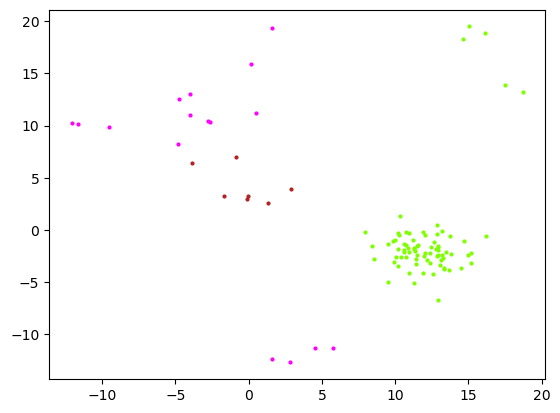

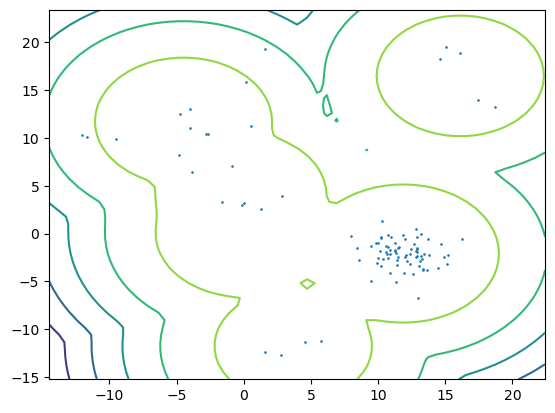

In [4960]:
elbo_n, nu_k_n = var_dpmm_n(X, alpha, sigma, T = K, n_iter = 1000)

Initialization 0
  Iteration 10	 time lapse 0.01093s	 ll change 0.70648
  Iteration 20	 time lapse 0.00374s	 ll change 1.59180
  Iteration 30	 time lapse 0.00309s	 ll change 0.10930
Initialization converged: True	 time lapse 0.02014s	 ll -599.89184
[[12.18657195 -4.02360582]
 [-4.02360582 13.52550416]]
Components: 5


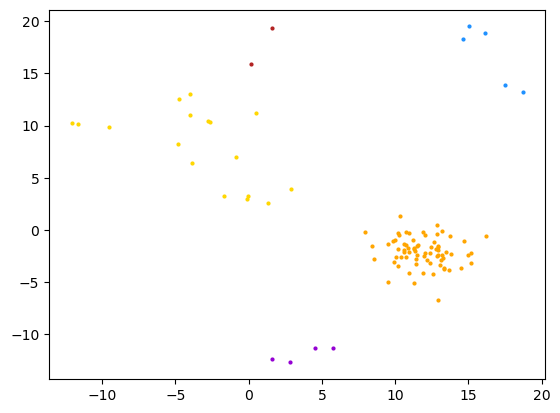

In [4961]:
sk_BGM = BayesianGaussianMixture(n_components=K, weight_concentration_prior=1, n_init=1,\
                                 covariance_type='tied', \
                                 max_iter=1000, \
                                 verbose=2)

sk_BGM.fit(X)

phi_sk = sk_BGM.weights_.reshape((K, 1))
#phi_sk = sk_BGM.predict_proba(X).T

mu_sk = sk_BGM.means_

print(sk_BGM.covariances_)
cov_sk = np.array([sk_BGM.covariances_ for _ in range(K)])
#cov_sk = sk_BGM.covariances_

plot_el(X, 0, 0, mu_sk, sk_BGM.covariances_, _, label_input = sk_BGM.predict(X)) # make sure the cluster plot is right. Now the prediction is wrong.

comp = 0
for i in range(K):
    if np.any(sk_BGM.predict(X) == i):
        comp += 1
print("Components:", comp)